# Project: Advanced Lane Finding

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
# Import all nessesery modules
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

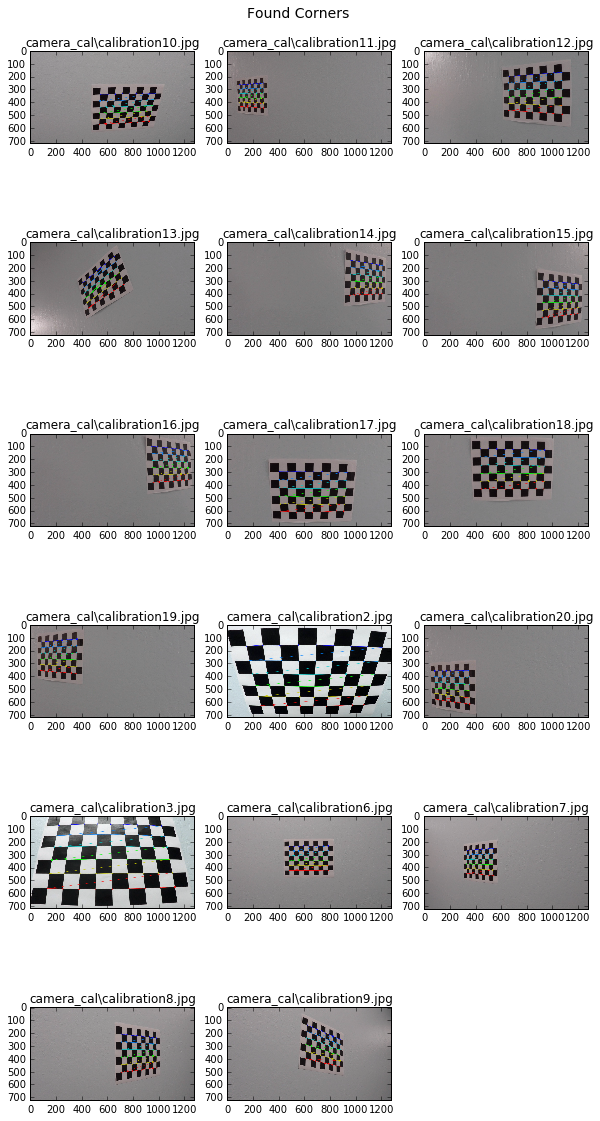

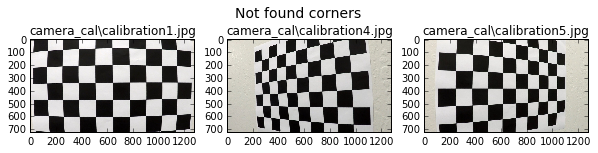

In [2]:
x_corners = 9 
y_corners = 6

objp = np.zeros((y_corners * x_corners,3), np.float32)
objp[:,:2] = np.mgrid[0:x_corners, 0:y_corners].T.reshape(-1,2)

objpoints = [] 
imgpoints = [] 

images = glob.glob('camera_cal/calibration*.jpg')

not_found = []

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.9,'Found Corners ', fontsize=14, ha='center')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x_corners,y_corners), None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_corners,y_corners), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        
    else:
        not_found.append(fname)
plt.show()

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.56 ,'Not found corners ', fontsize=14, ha='center')
for i, p in enumerate(not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) 
    plt.title(p)

plt.show()


In [3]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
                

## Apply a distortion correction to raw images.

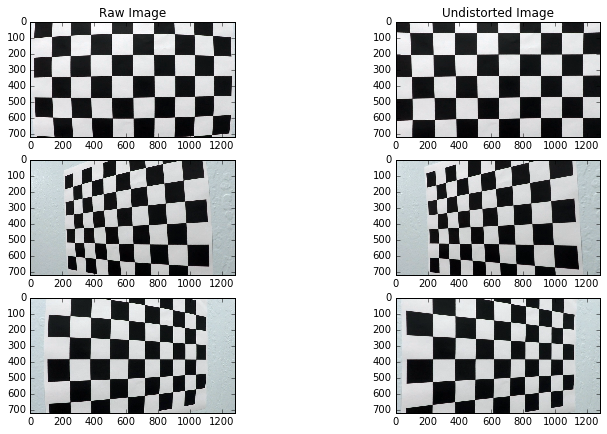

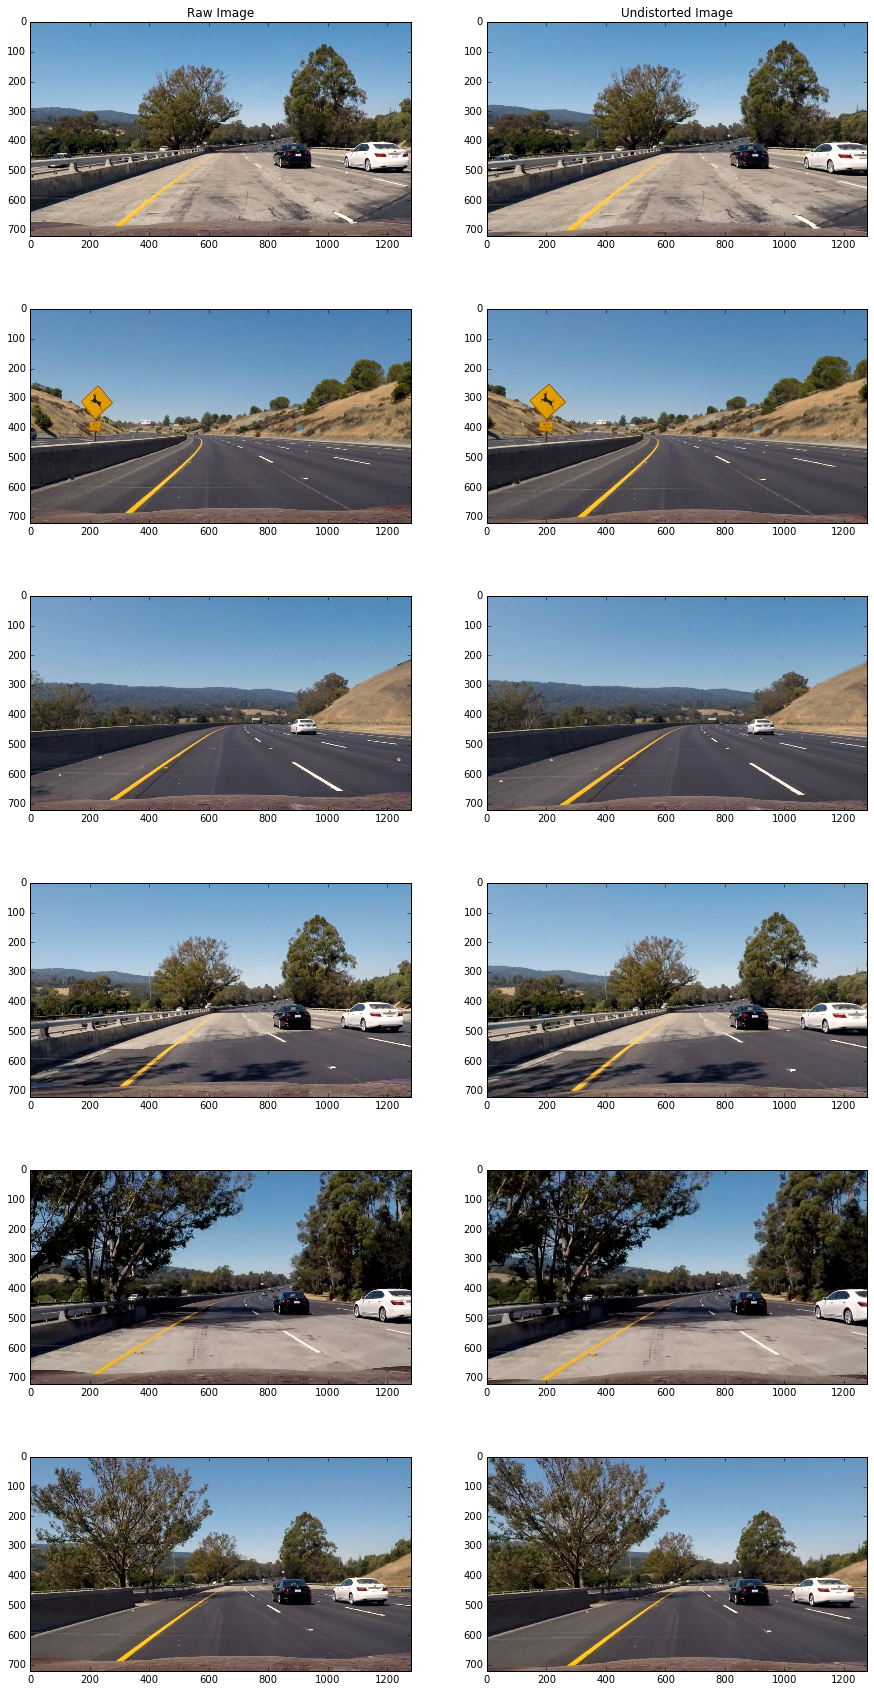

In [4]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = []
for i in not_found:
    img.append(cv2.imread(i))

    
img_size = (img[0].shape[1], img[0].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

plt.figure(figsize=(12, 7))

counter = 1
for i in img:
    plt.subplot(3, 2, counter)
    plt.imshow(i)
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(3, 2, counter)
    plt.imshow(undistort_img(i, mtx, dist))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1
   
test_images_files = glob.glob('test_images/test*.jpg')
test_images = []
for i in test_images_files:
    test_images.append(cv2.imread(i))


plt.figure(figsize=(15, 30))
counter = 1

for i in test_images:
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(undistort_img(i, mtx, dist), cv2.COLOR_BGR2RGB))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1

## Use color transforms, gradients, etc., to create a thresholded binary image.

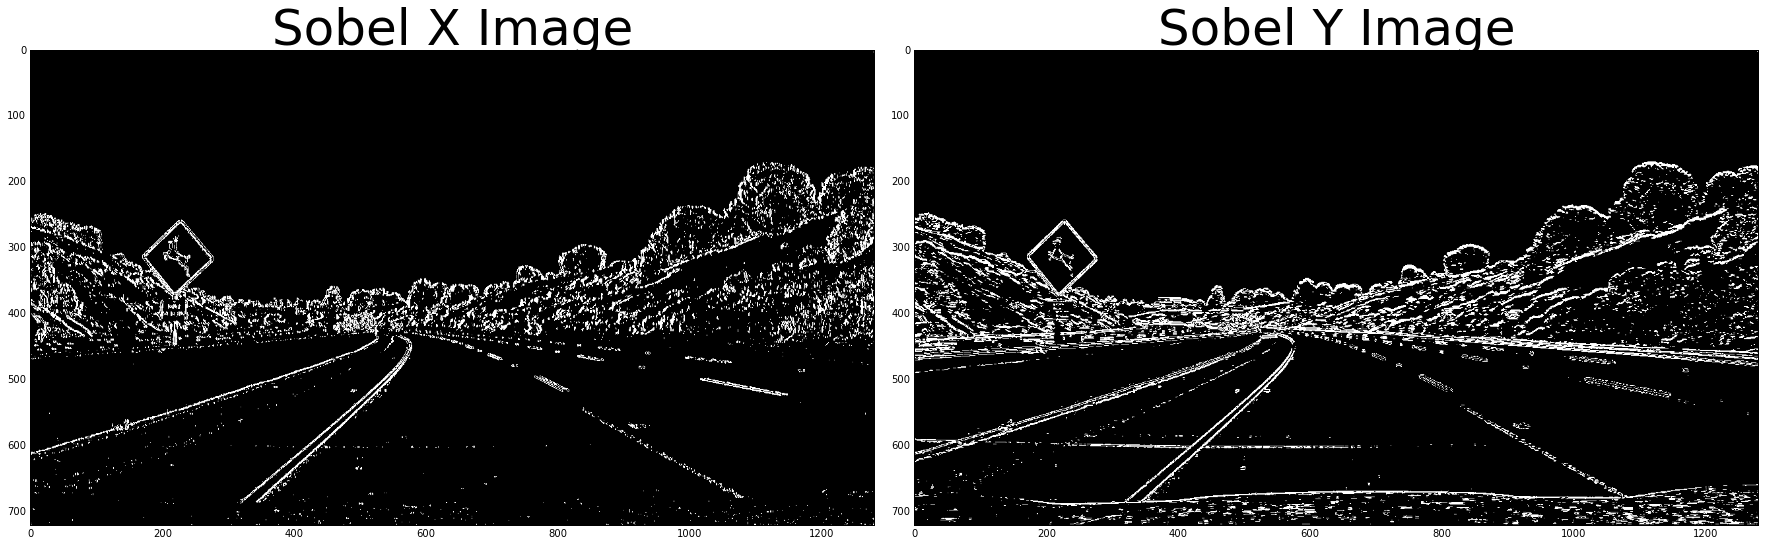

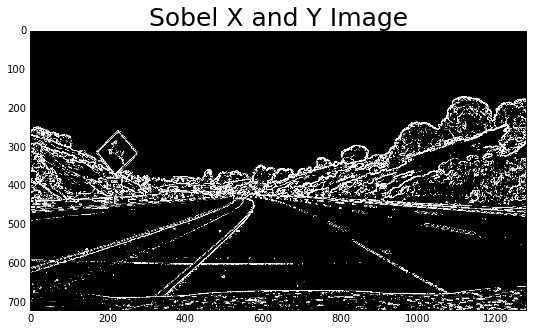

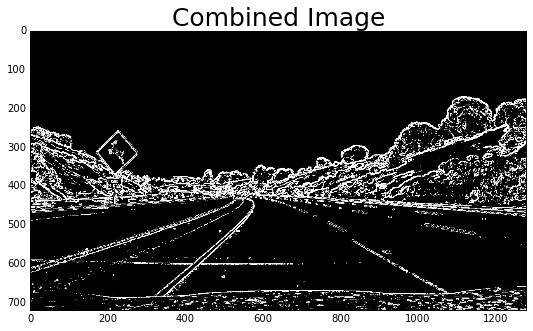

In [5]:
img = cv2.imread('test_images/test2.jpg')
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

## test results

abs_sobel_x_img = abs_sobel_thresh(img, 'x', 3, (20, 100))
abs_sobel_y_img = abs_sobel_thresh(img, 'y', 3, (20, 100))
abs_sobel_xy_img = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(abs_sobel_x_img, cmap='gray')
ax1.set_title('Sobel X Image', fontsize=50)
ax2.imshow(abs_sobel_y_img, cmap='gray')
ax2.set_title('Sobel Y Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure(figsize=(15, 5))
plt.imshow(abs_sobel_xy_img, cmap='gray')
plt.title('Sobel X and Y Image', fontsize=25)



gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))
dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))


combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(15, 5))
plt.imshow(combined, cmap='gray')
plt.title('Combined Image', fontsize=25)

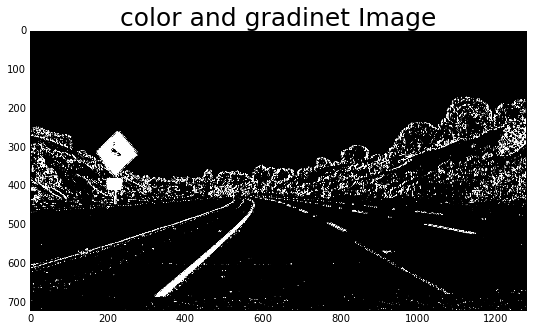

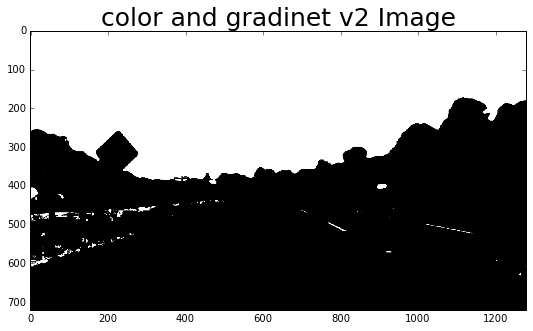

In [6]:
def apply_color_gradient_v2(img, thresh=(20,100), s_thresh=(220,255), b_thresh=(190,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    
    b_binary = np.zeros_like(lab_b)
    b_binary[((lab_b > b_thresh[0]) & (lab_b <= b_thresh[1]))] = 1


    combined_binary = np.zeros_like(b_binary)
    #combined_binary[(l_binary == 1) | (gradx == 1) | (b_binary == 1)] = 1    
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1    
    
    return combined_binary

    

def apply_color_gradient(img, xgrad_thresh=(20,100), s_thresh=(170,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

img_color_gradient_normalized = apply_color_gradient(img)

plt.figure(figsize=(15, 5))
plt.imshow(img_color_gradient_normalized, cmap='gray')
plt.title('color and gradinet Image', fontsize=25)

img_color_gradient = apply_color_gradient_v2(img)
plt.figure(figsize=(15, 5))
plt.imshow(img_color_gradient, cmap='gray')
plt.title('color and gradinet v2 Image', fontsize=25)

## Apply a perspective transform to rectify binary image ("birds-eye view").

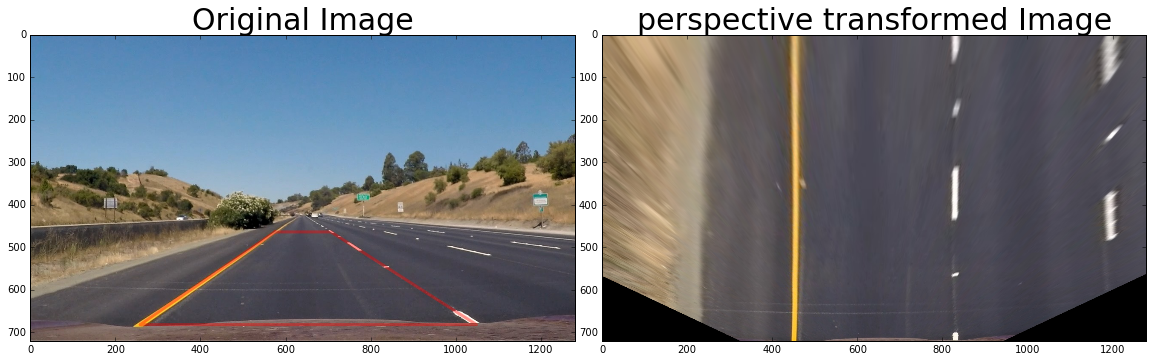

In [7]:
def perspective_transform(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

img = cv2.imread('test_images/straight_lines1.jpg')

h,w = img.shape[:2]

src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = perspective_transform(img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('perspective transformed Image', fontsize=30)


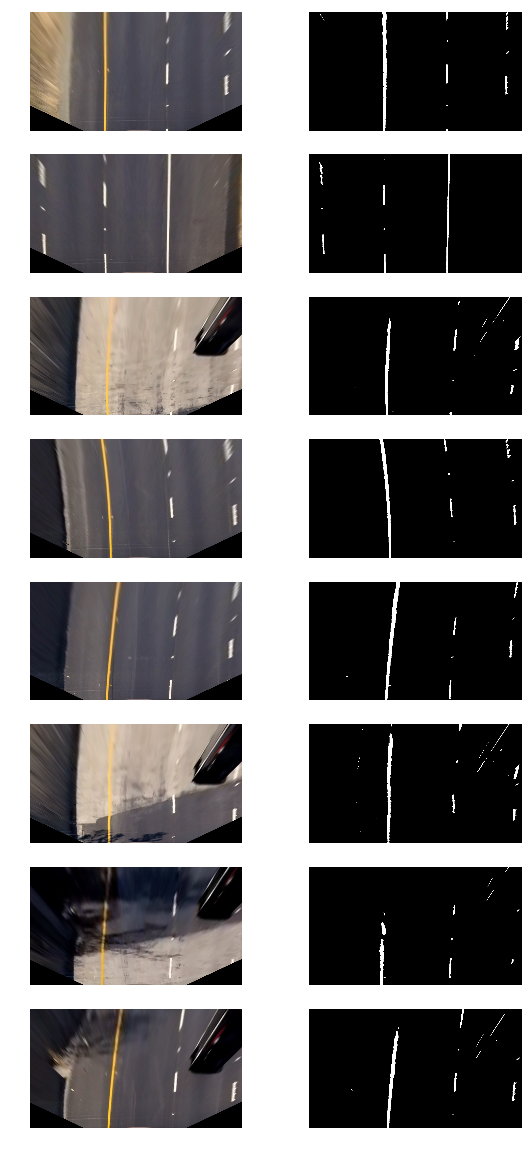

In [8]:
imshape = img_color_gradient.shape

vertices = np.array([[(0,imshape[0] - 330),(0, imshape[0]), (imshape[1], imshape[0]), (imshape[1],imshape[0] - 330)]], dtype=np.int32)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image



def processing_pipeline(img, mtx, dist, vertices, src, dst):
    
    gblur = cv2.GaussianBlur(img, (5,5), 20.0)
    img = cv2.addWeighted(img, 2, gblur, -1, 0)
    
    img = region_of_interest(img, vertices)
    
    img = undistort_img(img, mtx, dist)    
    
    img, M, Minv = perspective_transform(img, src, dst)
    
    img = apply_color_gradient_v2(img)
    
    
    return img, Minv

images = glob.glob('./test_images/*.jpg')
                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img_bin, _ = processing_pipeline(img, mtx, dist, vertices, src, dst)
    img = undistort_img(img, mtx, dist)
    img, M, Minv = perspective_transform(img, src, dst)
    
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

## Detect lane pixels and fit to find the lane boundary.

In [9]:
def sliding_windows_fit(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 80
    
    minpix = 40
    
    left_lane_inds = []
    right_lane_inds = []    
    rectangle_data = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)

    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


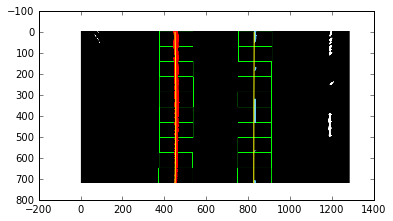

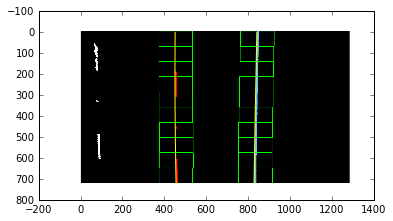

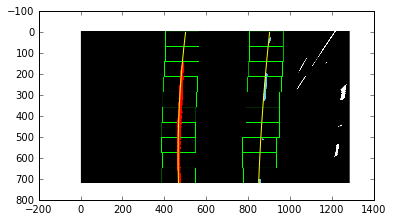

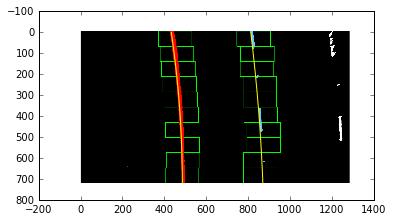

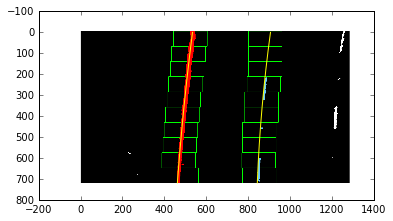

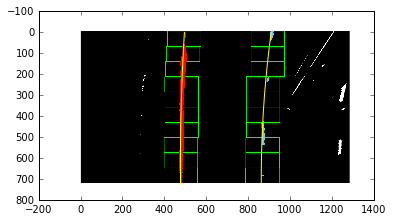

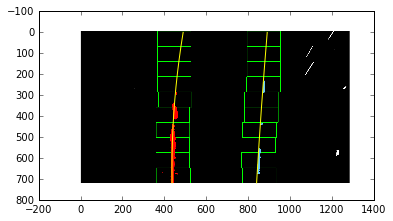

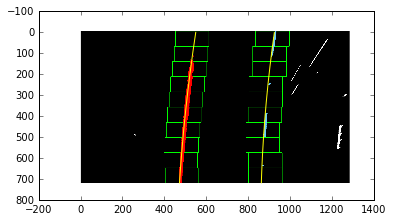

In [10]:
def processing_fit_poly(img, mtx, dist, vertices, src, dst):
    exampleImg_bin, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_windows_fit(exampleImg_bin)

    h = img.shape[0]
    
    #left_fit[0] = (left_fit[0] + right_fit[0])/2.
    #right_fit[0] = (left_fit[0] + right_fit[0])/2.
    
    #left_fit[1] = (left_fit[1] + right_fit[1])/2.
    #right_fit[1] = (left_fit[1] + right_fit[1])/2.

    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    


    rectangles = visualization_data[0]
    histogram = visualization_data[1]

    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)

    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    for rect in rectangles:
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
        
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    
images = glob.glob('./test_images/*.jpg')

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processing_fit_poly(img, mtx, dist, vertices, src, dst)

In [11]:
def processing_fit_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

## Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
def calc_curvature(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    
    ym_per_pix = 3.05/100
    xm_per_pix = 3.7/378
    
    left_curverad = 0
    right_curverad = 0
    center_dist = 0
    h = bin_img.shape[0]
    
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

## Warp the detected lane boundaries back onto the original image.

In [13]:
def draw_lane_pipeline(img, binary_img ,left_fit, right_fit, Minv):
        
    if left_fit is None or right_fit is None:
        return img
    
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    
    # calculate left and right lane x 
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    return result

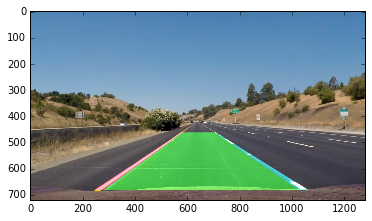

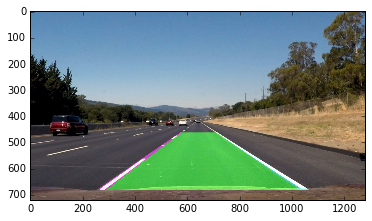

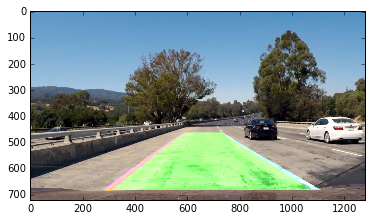

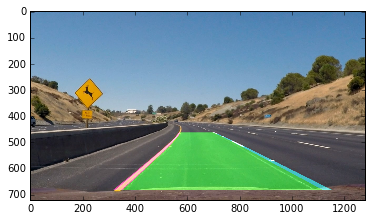

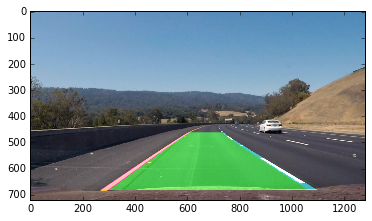

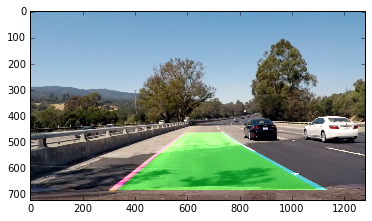

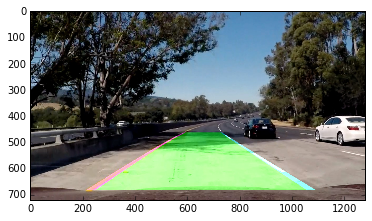

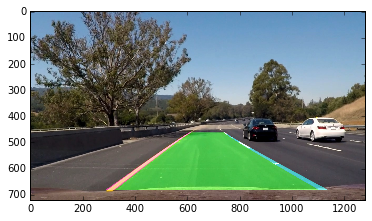

In [14]:
images = glob.glob('./test_images/*.jpg')

for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bin_img, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_windows_fit(bin_img)
    
    res_img = draw_lane_pipeline(img, bin_img, left_fit, right_fit, Minv)
    plt.figure()
    plt.imshow(res_img)
    


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [15]:
def draw_info(img, curv_rad, center_dist):
    
    h = img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curv_rad) + '(m)'
    cv2.putText(img, text, (40,70), font, 2, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (40,120), font, 2, (255,255,255), 2, cv2.LINE_AA)
    return img

In [40]:
def updateLane(Lane, fit, shape, speed):
        keeping_data_size = int(30*5/(speed*1000/3600))
    
        if fit is not None:
            if Lane.best_fit is not None:
                Lane.diffs = abs(fit-Lane.best_fit)
            
            if (Lane.diffs[0] > 0.001 or Lane.diffs[1] > 1.0 or Lane.diffs[2] > 100.) and len(Lane.current_fit) > 0:
            #if (abs(2*Lane.diffs[0]*shape[0] + Lane.diffs[1]) > 0.25 or Lane.diffs[2] > 100.) and len(Lane.current_fit) > 0:
                print(abs(2*Lane.diffs[0]*shape[0] + Lane.diffs[1]), shape)
                Lane.detected = False
            else:
                Lane.detected = True
                Lane.current_fit.append(fit)
                if len(Lane.current_fit) > keeping_data_size:
                    Lane.current_fit.pop(0)
                Lane.best_fit = np.average(Lane.current_fit, axis=0)
        else:
            Lane.detected = False
            if len(Lane.current_fit) > 1:
                Lane.current_fit.pop()
                Lane.best_fit = np.average(Lane.current_fit, axis=0)
        
        return Lane
    


def lane_detection_pipeline(img):
    
    global left_line, right_line
    shape = img.shape
    
    img_bin, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    if left_line.detected is not None or right_line.detected is not None:
    
        left_fit, right_fit, l_lane_inds, r_lane_inds, _ = sliding_windows_fit(img_bin)
    else:
        left_fit, right_fit, l_lane_inds, r_lane_inds = processing_fit_prev_fit(img_bin, left_line.best_fit, right_line.best_fit)
                      
    left_line = updateLane(left_line, left_fit, shape, 100)
    right_line = updateLane(right_line, right_fit, shape, 100)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        
        img_out1 = draw_lane_pipeline(img, img_bin, left_line.best_fit, right_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curvature(img_bin, left_line.best_fit, right_line.best_fit, l_lane_inds, r_lane_inds)
        img_out = draw_info(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        return img
    
    return img_out


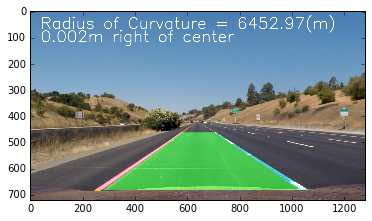

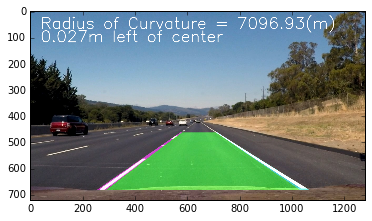

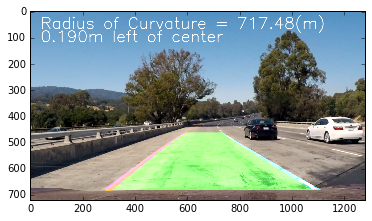

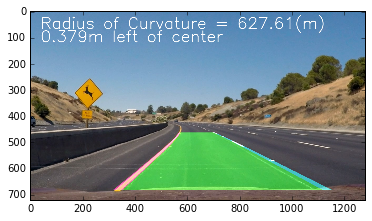

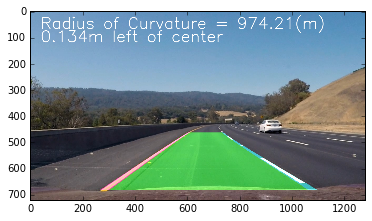

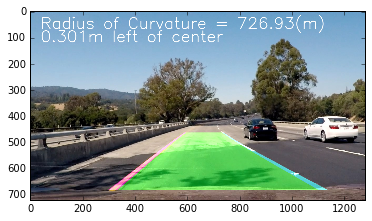

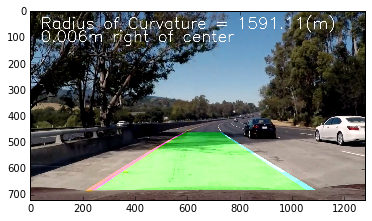

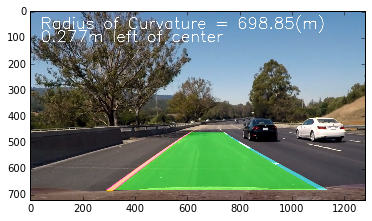

In [42]:
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    left_line = Line()
    right_line = Line()
    
    res_img = lane_detection_pipeline(img)

    plt.figure()
    plt.imshow(res_img)

In [43]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()

output_video = 'project4_adv_lane_video.mp4'
input_video = VideoFileClip('project_video.mp4')
processed_video = input_video.fl_image(lane_detection_pipeline)
processed_video.write_videofile(output_video, audio=False)

input_video.reader.close()
input_video.audio.reader.close_proc()

[MoviePy] >>>> Building video project4_adv_lane_video.mp4
[MoviePy] Writing video project4_adv_lane_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:00<00:00,  5.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4_adv_lane_video.mp4 



In [41]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()

output_video = 'project4_challenge_adv_lane_video.mp4'
input_video = VideoFileClip('challenge_video.mp4')
processed_video = input_video.fl_image(lane_detection_pipeline)

processed_video.write_videofile(output_video, audio=False)

input_video.reader.close()
input_video.audio.reader.close_proc()

[MoviePy] >>>> Building video project4_challenge_adv_lane_video.mp4
[MoviePy] Writing video project4_challenge_adv_lane_video.mp4


 11%|████▍                                    | 52/485 [00:09<01:20,  5.36it/s]

1.4459604463 (720, 1280, 3)


 11%|████▋                                    | 55/485 [00:10<01:21,  5.30it/s]

1.36198213201 (720, 1280, 3)


 12%|████▋                                    | 56/485 [00:10<01:22,  5.22it/s]

1.2060944846 (720, 1280, 3)


 14%|█████▌                                   | 66/485 [00:12<01:13,  5.68it/s]

1.62978566692 (720, 1280, 3)


 23%|█████████▏                              | 112/485 [00:20<01:07,  5.53it/s]

2.07821879609 (720, 1280, 3)


 27%|██████████▋                             | 129/485 [00:23<01:06,  5.38it/s]

5.26414895108 (720, 1280, 3)


 31%|████████████▎                           | 150/485 [00:27<00:51,  6.50it/s]

0.683155716398 (720, 1280, 3)


 32%|████████████▋                           | 154/485 [00:27<00:52,  6.26it/s]

0.726511394258 (720, 1280, 3)


 32%|████████████▊                           | 155/485 [00:28<00:54,  6.03it/s]

1.43498121123 (720, 1280, 3)


 32%|████████████▊                           | 156/485 [00:28<00:57,  5.77it/s]

1.41860075277 (720, 1280, 3)


 32%|████████████▉                           | 157/485 [00:28<00:57,  5.66it/s]

1.48874796511 (720, 1280, 3)


 33%|█████████████                           | 158/485 [00:28<00:59,  5.52it/s]

1.5433872705 (720, 1280, 3)


 33%|█████████████                           | 159/485 [00:28<01:00,  5.38it/s]

1.09091698062 (720, 1280, 3)


 33%|█████████████▏                          | 160/485 [00:28<01:00,  5.35it/s]

0.690983600328 (720, 1280, 3)


 33%|█████████████▎                          | 161/485 [00:29<01:01,  5.28it/s]

0.875545945214 (720, 1280, 3)


 33%|█████████████▎                          | 162/485 [00:29<01:02,  5.15it/s]

0.849891579858 (720, 1280, 3)


 34%|█████████████▍                          | 163/485 [00:29<01:01,  5.26it/s]

0.747828041043 (720, 1280, 3)


 34%|█████████████▌                          | 164/485 [00:29<01:02,  5.12it/s]

0.753272930378 (720, 1280, 3)


 34%|█████████████▌                          | 165/485 [00:29<01:00,  5.28it/s]

0.551894123335 (720, 1280, 3)


 34%|█████████████▋                          | 166/485 [00:30<01:00,  5.28it/s]

0.564470456439 (720, 1280, 3)


 34%|█████████████▊                          | 167/485 [00:30<00:59,  5.36it/s]

0.613595078846 (720, 1280, 3)


 35%|█████████████▊                          | 168/485 [00:30<01:00,  5.20it/s]

0.668290484882 (720, 1280, 3)


 57%|██████████████████████▊                 | 277/485 [00:51<00:38,  5.34it/s]

1.33104420269 (720, 1280, 3)


 58%|███████████████████████                 | 280/485 [00:51<00:39,  5.25it/s]

1.2268324517 (720, 1280, 3)


 80%|███████████████████████████████▊        | 386/485 [01:11<00:19,  4.95it/s]

1.73277687862 (720, 1280, 3)


 94%|█████████████████████████████████████▌  | 456/485 [01:24<00:05,  5.13it/s]

1.51400148533 (720, 1280, 3)


 97%|██████████████████████████████████████▋ | 469/485 [01:27<00:02,  5.42it/s]

3.55487395043 (720, 1280, 3)


 97%|██████████████████████████████████████▊ | 470/485 [01:27<00:02,  5.25it/s]

3.22431414722 (720, 1280, 3)


 97%|██████████████████████████████████████▊ | 471/485 [01:27<00:02,  5.35it/s]

2.17961475074 (720, 1280, 3)


 97%|██████████████████████████████████████▉ | 472/485 [01:27<00:02,  5.28it/s]

3.20355678445 (720, 1280, 3)


 98%|███████████████████████████████████████▎| 477/485 [01:28<00:01,  5.38it/s]

11.3391662917 (720, 1280, 3)


 99%|███████████████████████████████████████▍| 478/485 [01:29<00:01,  5.25it/s]

4.58270719094 (720, 1280, 3)


100%|████████████████████████████████████████| 485/485 [01:30<00:00,  5.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4_challenge_adv_lane_video.mp4 

